In [144]:
import random

import cv2
from matplotlib import pyplot as plt
import json
from PIL import Image
import numpy as np 

import albumentations as A

In [145]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)
    
    
def boxCreate(points):
    
    x_min = min(points[0][0], points[1][0])
    y_min = min(points[0][1], points[1][1])
    x_max = max(points[0][0], points[1][0])
    y_max = max(points[0][1], points[1][1])

    width = x_max - x_min
    height = y_max - y_min

    return [x_min, y_min, width, height]


def bbox_to_coords(bbox):
    
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    
    return [[x_max, y_max],[x_min, y_min]]

In [146]:
image = cv2.imread('../Database/tile_4_90.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [147]:
json_file_path = "../Database/tile_4_90.json"

# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2}
category_id_to_name = {1:'commercial_building', 2:'residential_building'}


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))
    

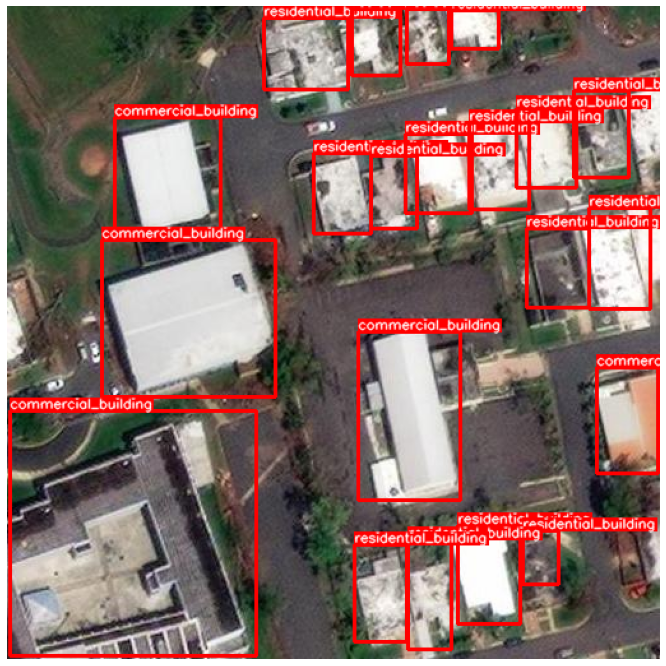

In [148]:
visualize(image, bboxes, category_ids, category_id_to_name)

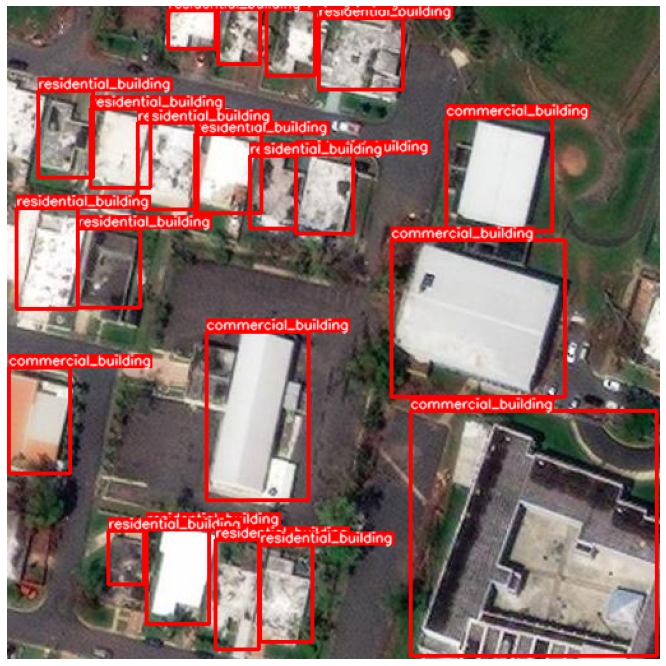

In [149]:
# Flip Transformation

transform = A.Compose(
    [A.HorizontalFlip(p=0.5)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [110]:
random.seed(17)
transform = A.Compose(
    [A.CenterCrop(height=280, width=280, p=1)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)

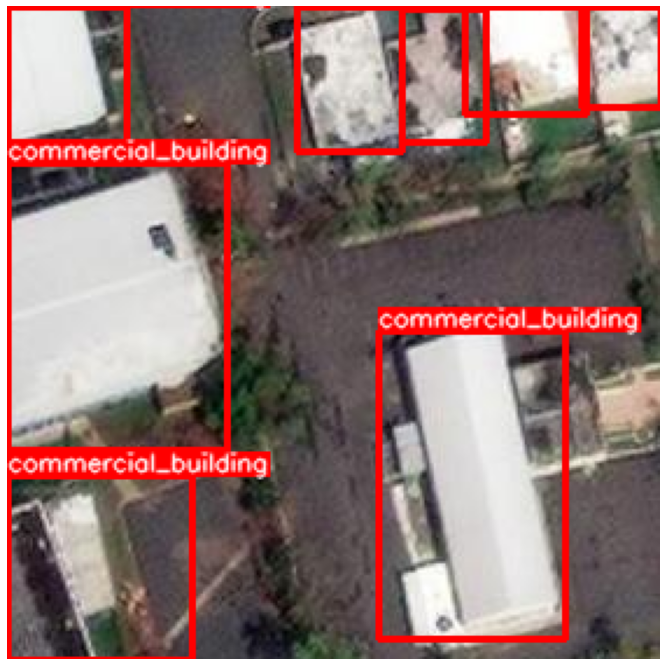

In [111]:
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)

In [112]:
# Assuming transformed['image'] is a NumPy array
augmented_image_np = transformed['image']
augmented_image_pil = Image.fromarray(np.uint8(augmented_image_np))

# Save the image in JPG format
augmented_image_pil.save("augmented_image.jpg")

In [209]:

# Load your image (replace 'your_image.jpg' with your image path)
image = Image.open('../Database/tile_4_90.jpg')

# Define your transformation pipeline (random crop and padding)
transform = A.Compose([
    A.RandomCrop(width=256, height=256),  # Change width and height as needed
    A.PadIfNeeded(min_height=image.size[1], min_width=image.size[0], border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0)),
    bbox_params={'bboxes': bboxes, 'category_ids': category_ids})
])

# Apply the transformation
transformed = transform(image=np.array(image))

# Get the transformed image
transformed_image = transformed['image']

# Convert NumPy array back to PIL Image
transformed_image_pil = Image.fromarray(transformed_image)

# Save the transformed image (replace 'transformed_image.jpg' with your desired filename)
transformed_image_pil.save("transformed_image.jpg")

SyntaxError: invalid syntax (<ipython-input-209-e85c2a9584e5>, line 8)

In [204]:
json_dict = {
    "version": "5.4.1",
    "flags": {},
    "shapes": []
}


def shapesElementMaker(transformed):
    shapes = []
    
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        subdict = {
            "label": category_id_to_name[category_id],
            "points": bbox_to_coords(bbox),
            "group_id": 'null',
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "mask": 'null'
        }
        shapes.append(subdict)
    
    return shapes

json_dict["shapes"] = shapesElementMaker(transformed= transformed_image)

with open('json_transformed.json', 'w') as json_file:
    json.dump(json_dict, json_file)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Open the new pic

In [203]:
image = cv2.imread('./padded_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [201]:
json_file_path = "json_transformed.json"

# Open the JSON file and load its contents
with open(json_file_path, "r") as f:
    data = json.load(f)

bboxes = []
category_ids = []

category_name_to_id = {'commercial_building':1, 'residential_building':2}
category_id_to_name = {1:'commercial_building', 2:'residential_building'}


for i in range(len(data['shapes'])):
    
    label = data['shapes'][i]['label']
    shape = data['shapes'][i]['points']
    
    category_ids.append(category_name_to_id[label])
    bboxes.append(boxCreate(shape))
    
bboxes

[[344.135593220339, 87.07344632768361, 83.05084745762707, 89.26553672316383],
 [301.76271186440675,
  183.11864406779662,
  136.15819209039552,
  123.16384180790956],
 [156.56497175141243,
  255.43502824858757,
  80.22598870056498,
  132.20338983050846],
 [316.45197740112997,
  317.58192090395477,
  193.22033898305085,
  191.52542372881356],
 [244.70056497175142, 9.107344632768363, 65.53672316384183, 55.93220338983052],
 [203.4576271186441, 2.327683615819212, 38.418079096045176, 52.54237288135593],
 [165.6045197740113,
  2.327683615819212,
  33.333333333333314,
  43.502824858757066],
 [126.0564971751412, 3.45762711864407, 37.853107344632804, 30.50847457627119],
 [226.6214689265537, 115.3220338983051, 45.197740112994325, 63.2768361581921],
 [190.46327683615817,
  117.01694915254238,
  36.15819209039552,
  57.06214689265535],
 [147.5254237288135, 100.0677966101695, 51.97740112994353, 62.146892655367225],
 [102.32768361581918, 91.59322033898306, 47.4576271186441, 68.36158192090394],
 [65.

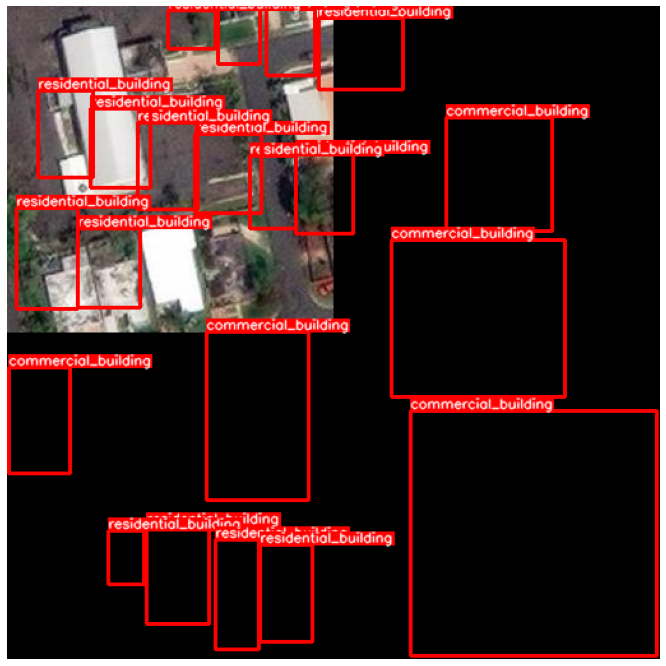

In [202]:
visualize(image, bboxes, category_ids, category_id_to_name)